# Basic end-to-end training of a LightGBM model

Features that are illustrated in this kernel:
- data reading with memory footprint reduction
- categorical feature encoding using one-hot-encoding (OHE)
- resampling to address imbalance of different categories in the data
- gradient-boosted decision trees using _**LightGBM**_ package
- early stopping in _**LightGBM**_ model training to avoid overtraining
- hyperparameter optimisation of the model using random search in cross validation
- submission preparation
This kernel inherited ideas and SW solutions from other public kernels and in such cases I will post direct references to the original product, that that you can get some additional insights from the source.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
PATH = "/home/mlisovyi/.kaggle/competitions/home-credit-default-risk/"
print(os.listdir(PATH))

# Any results you write to the current directory are saved as output.

['application_test.csv', 'bureau.csv', 'bureau_balance.csv', 'installments_payments.csv.zip', 'credit_card_balance.csv.zip', 'sample_submission.csv', 'credit_card_balance.csv', 'application_train.csv.zip', 'application_test.csv.zip', 'previous_application.csv', 'sample_submission.csv.zip', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'bureau_balance.csv.zip', 'application_train.csv', 'bureau.csv.zip', 'previous_application.csv.zip', 'POS_CASH_balance.csv.zip']


## Read in the data reducing memory pattern for variables.
The implementation was copied over from [this kernel](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
application_train = import_data(PATH+'application_train.csv')
application_test = import_data(PATH+'application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


## Categorical encoding
The function was taken from [this kernel](https://www.kaggle.com/sz8416/simple-intro-eda-baseline-model-with-gridsearch). It allows to do OneHotEncoding (OHE) keeping only those columns that are common to train and test samples. OHE is performed using `pd.get_dummies`, which allows to convert categorical features, while keeping numerical untouched

In [4]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=True)
    test_d = pd.get_dummies(test, drop_first=True)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d
application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)

Memory usage of train increases from 59.54 to 90.33 MB
Memory usage of test increases from 9.40 to 14.27 MB


## Deal with category imbalance
Use a standard library to to random undersampling on the dominating category

In [5]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=314)
X_rus, y_rus = rus.fit_sample(application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(-1), 
                              application_train_ohe['TARGET'])

# Model fitting with HyperParameter optimisation
We will use LightGBM classifier - LightGBM allows to build very sophysticated models with a very short training time.
### Split the full sample into train/test (80/20)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314)

### Use test subset for early stopping criterion 
This allows us to avoid overtraining and we do not need to optimise the number of trees

In [7]:
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100}

### Set up HyperParameter search
We use random search, which is more flexible and more efficient than a grid search

In [8]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_data_in_leaf': sp_randint(100, 500), 
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [9]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 20

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 1000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=1000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

In [10]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.75978
Early stopping, best iteration is:
[143]	valid's auc: 0.761322
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.758901
Early stopping, best iteration is:
[123]	valid's auc: 0.760096
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.760138
Early stopping, best iteration is:
[173]	valid's auc: 0.761772
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.759892
Early stopping, best iteration is:
[160]	valid's auc: 0.761676
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.760505
Early stopping, best iteration is:
[119]	valid's auc: 0.761163
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.76197
Early stopping, best iteration is:
[114]	valid's auc: 0.762403
Training until validat

Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.758413
Early stopping, best iteration is:
[107]	valid's auc: 0.758905
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[89]	valid's auc: 0.758427
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.759851
Early stopping, best iteration is:
[108]	valid's auc: 0.760293
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.758525
Early stopping, best iteration is:
[114]	valid's auc: 0.759022
Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.761435
Early stopping, best iteration is:
[100]	valid's auc: 0.761435
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[59]	valid's auc: 0.756555
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[71]	valid's auc: 0.757215
Training until v

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.761138
Early stopping, best iteration is:
[155]	valid's auc: 0.76234
Best score reached: 0.756326990767207 with params: {'subsample': 0.9326466073236168, 'min_data_in_leaf': 301, 'colsample_bytree': 0.9501241488957805, 'reg_lambda': 100, 'reg_alpha': 0, 'num_leaves': 28} 


### Look at the performance of the top-5 parameter choices
(the list is inverted)

In [11]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
                                    gs.cv_results_['mean_test_score'][i], 
                                    gs.cv_results_['mean_train_score'][i],
                                    gs.cv_results_['std_test_score'][i]))

Valid+-Std     Train  :   Parameters
0.755+-0.004     0.775   :  {'subsample': 0.6362647988131058, 'min_data_in_leaf': 322, 'colsample_bytree': 0.46175306323300236, 'reg_lambda': 20, 'reg_alpha': 0.1, 'num_leaves': 8}
0.755+-0.003     0.807   :  {'subsample': 0.9519134298608098, 'min_data_in_leaf': 171, 'colsample_bytree': 0.9731668400523877, 'reg_lambda': 10, 'reg_alpha': 2, 'num_leaves': 22}
0.756+-0.004     0.792   :  {'subsample': 0.858216412736859, 'min_data_in_leaf': 250, 'colsample_bytree': 0.5645098230355559, 'reg_lambda': 50, 'reg_alpha': 10, 'num_leaves': 16}
0.756+-0.004     0.790   :  {'subsample': 0.9969185790275723, 'min_data_in_leaf': 221, 'colsample_bytree': 0.9891800664272259, 'reg_lambda': 10, 'reg_alpha': 2, 'num_leaves': 11}
0.756+-0.003     0.811   :  {'subsample': 0.9326466073236168, 'min_data_in_leaf': 301, 'colsample_bytree': 0.9501241488957805, 'reg_lambda': 100, 'reg_alpha': 0, 'num_leaves': 28}


/home/mlisovyi/anaconda2/envs/Titanic/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Plot feature importance

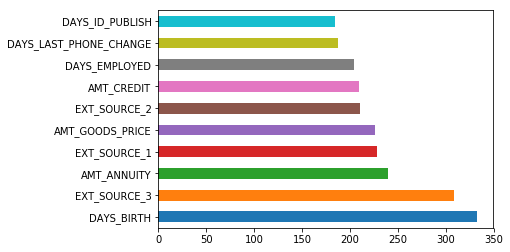

In [12]:
feat_imp = pd.Series(gs.best_estimator_.feature_importances_, index=application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(10).plot(kind='barh')

## Build the final model
We do training with the 0.8 subset of the dataset and 0.2 subset for early stopping. We use the tuned parameter values but a smaller learning rate to allow smoother convergence to the minimum

In [13]:
clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())
#force larger number of max trees and smaller learning rate
clf_final.set_params(n_estimators=5000, learning_rate=0.005)
clf_final.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
[100]	valid's auc: 0.721485
[200]	valid's auc: 0.727349
[300]	valid's auc: 0.732482
[400]	valid's auc: 0.737071
[500]	valid's auc: 0.741618
[600]	valid's auc: 0.745241
[700]	valid's auc: 0.748159
[800]	valid's auc: 0.750491
[900]	valid's auc: 0.752363
[1000]	valid's auc: 0.753975
[1100]	valid's auc: 0.755421
[1200]	valid's auc: 0.756637
[1300]	valid's auc: 0.757761
[1400]	valid's auc: 0.758705
[1500]	valid's auc: 0.759599
[1600]	valid's auc: 0.760481
[1700]	valid's auc: 0.761169
[1800]	valid's auc: 0.761649
[1900]	valid's auc: 0.762098
[2000]	valid's auc: 0.762588
[2100]	valid's auc: 0.762947
[2200]	valid's auc: 0.763228
[2300]	valid's auc: 0.76345
[2400]	valid's auc: 0.763687
Early stopping, best iteration is:
[2467]	valid's auc: 0.763846


LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9501241488957805, learning_rate=0.005,
        max_depth=-1, metric='None', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=301, min_split_gain=0.0,
        n_estimators=5000, n_jobs=4, num_leaves=28, objective=None,
        random_state=314, reg_alpha=0, reg_lambda=100, silent=True,
        subsample=0.9326466073236168, subsample_for_bin=200000,
        subsample_freq=1)

# Predict on the submission test sample

In [14]:
probabilities = gs.best_estimator_.predict_proba(application_test_ohe.drop(['SK_ID_CURR'], axis=1).fillna(-1))
submission = pd.DataFrame({
    'SK_ID_CURR': application_test_ohe['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
submission.to_csv("submission.csv", index=False)